In [1]:
import numpy as np
from scipy.interpolate import spline
import basis_set_exchange as bse
from pyscf import gto,scf
from pyscf.grad import rhf as grhf
from pyscf.hessian import rhf as hrhf
from matplotlib import pyplot as plt
import sys
sys.path.append( '/home/administrator/Documenti/APDFT/prototyping/hessian/AAFF/Libs')


In [2]:
%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

In [3]:
from Morse import Morse_interpolator

In [4]:
def MorseV(r,D,a,re):
    return D*(np.exp(-2*a*(r-re))-2*np.exp(-a*(r-re)))+D

In [5]:
def Morse_dE(r,r_e,a,De):
    return De*((np.exp(a*(r_e-r))-1)**2)

## Minima for N2, CO

In [6]:
pcx2=bse.get_basis("pcX-2",fmt="nwchem",elements=[6,8])

In [7]:
mol=gto.M(atom="C 0 0 0;O 0 0 2.08272", unit="Bohr",basis=pcx2)
mf=scf.RHF(mol)
e_min=mf.scf()
mf.Gradients().grad()[1,2]

converged SCF energy = -112.786616218695
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000    -0.0000000000    -0.0000019315
1 O     0.0000000000     0.0000000000     0.0000019315
----------------------------------------------


1.9314628296740466e-06

In [8]:
R0=1.9
mol=gto.M(atom="C 0 0 0;O 0 0 {}".format(R0), unit="Bohr",basis=pcx2)
mf=scf.RHF(mol)
e_co=mf.scf()
g=mf.Gradients().grad()[1,2]
h=mf.Hessian().hess()[1,1,2,2]

converged SCF energy = -112.754571293095
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000    -0.0000000000     0.3916813613
1 O     0.0000000000     0.0000000000    -0.3916813613
----------------------------------------------


In [9]:
mi=Morse_interpolator(g,h,R0,.5,e_co)

In [10]:
mi.re,mi.e_min

(2.082352972263771, -112.78654413261536)

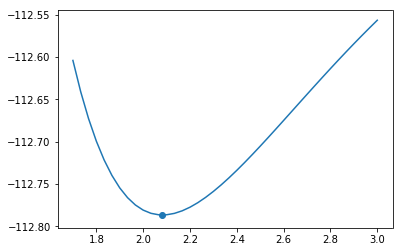

In [11]:
ls=np.linspace(1.7,3.,40)
plt.plot(ls,mi.E(ls))
plt.scatter(*mi.minimum())

In [12]:
ec=scf.RHF(gto.M(atom="C 0 0 0",basis=pcx2)).scf()
eo=scf.RHF(gto.M(atom="O 0 0 0",basis=pcx2)).scf()

converged SCF energy = -37.6029290136078
converged SCF energy = -74.6877238559481


In [13]:
bde=ec+eo-e_co

In [14]:
g,h,bde

(-0.39168136132100173, 2.883365492917452, 0.4639184235390701)

In [15]:
def mpa(g_,h_,R0_,De_): # Morse Potential Approximation
    Z=g_**2/(2*De_)/h_
    for i in range(3):
        t=float(np.roots([1,-2,1-2*Z,+Z])[i])
        a=g_/(2*De_)/(t*(1-t))
        dX=np.log(t)/a
        if a>0 and t>0:
            return R0_+dX,a
    return -1

In [16]:
def Morse(r,r_e,a,De,R0,e0):
    return De*((np.exp(a*(r_e-r))-1)**2-(np.exp(a*(r_e-R0))-1)**2)+e0

In [17]:
mpa(g,h,R0,bde)

(2.0840743174398124, 1.269480817777039)

In [18]:
scan_r=np.linspace(1.7,2.4,31)
scan_e=[]
for r in scan_r:
    scan_e.append(scf.RHF(gto.M(atom="C 0 0 0;O 0 0 {}".format(r), unit="Bohr",basis=pcx2,verbose=0)).scf())

In [19]:
scan_r_I=np.linspace(1.7,2.4,3001)
scan_e_I=spline(scan_r,scan_e,scan_r_I)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


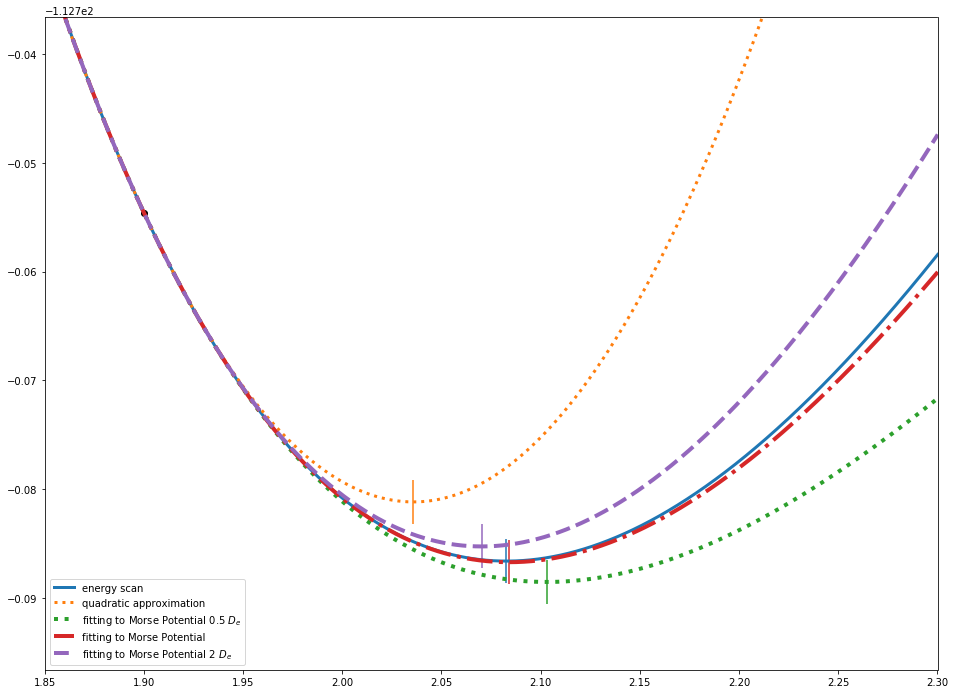

In [40]:
plt.figure(figsize=(16,12))
plt.scatter(R0,e_co,color="black")
plt.plot(scan_r_I,scan_e_I,lw=3,label="energy scan")
plt.scatter(scan_r_I[np.asarray(scan_e_I).argmin()],min(scan_e_I),marker='|',s=2000)
q_app1=e_co+h/2*(scan_r_I-R0)**2+g*(scan_r_I-R0)
plt.plot(scan_r_I,q_app1,ls=":",lw=3,label="quadratic approximation")
plt.scatter(scan_r_I[np.asarray(q_app1).argmin()],min(q_app1),marker='|',s=2000)
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,.5*bde) ,.5*bde,R0,e_co ),ls=":",lw=4,\
                                         label="fitting to Morse Potential $0.5 \ D_e $")
plt.scatter(scan_r_I[np.asarray(Morse(scan_r_I, *mpa(g,h,R0,.5*bde) ,.5*bde,R0,e_co)).argmin()],\
            min(Morse(scan_r_I, *mpa(g,h,R0,.5*bde) ,.5*bde,R0,e_co)),marker='|',s=2000)
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,bde) ,bde ,R0,e_co),ls="-." ,lw=4,\
                                         label="fitting to Morse Potential")
plt.scatter(scan_r_I[np.asarray(Morse(scan_r_I, *mpa(g,h,R0,bde),bde,R0,e_co)).argmin()],\
            min(Morse(scan_r_I, *mpa(g,h,R0,bde),bde,R0,e_co)),marker='|',s=2000)
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,2*bde) ,2*bde ,R0,e_co),ls="--",lw=4, \
                                         label="fitting to Morse Potential $2 \ D_e $")
plt.scatter(scan_r_I[np.asarray(Morse(scan_r_I, *mpa(g,h,R0,2*bde) ,2*bde,R0,e_co)).argmin()],\
            min(Morse(scan_r_I, *mpa(g,h,R0,2*bde) ,2*bde,R0,e_co)),marker='|',s=2000)
plt.ylim(e_min-.01,e_min+.05)
plt.xlim(1.85,2.3)
plt.legend()
plt.savefig("Morse_CO_1.png")

In [21]:
R02=2.3
mol=gto.M(atom="C 0 0 0;O 0 0 {}".format(R02), unit="Bohr",basis=pcx2)
mf=scf.RHF(mol)
e_co2=mf.scf()
g2=mf.Gradients().grad()[1,2]
h2=mf.Hessian().hess()[1,1,2,2]

converged SCF energy = -112.75844032207
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000     0.0000000000    -0.2281836918
1 O     0.0000000000    -0.0000000000     0.2281836918
----------------------------------------------


In [36]:
-g2/h2

-0.3431761371571346

In [22]:
def Morse2(r,r_e,a,De):
    return De*((np.exp(a*(r_e-r))-1)**2-(np.exp(a*(r_e-R02))-1)**2)+e_co2

In [23]:
bde2=ec+eo-e_co2
bde2

0.4677874525139032

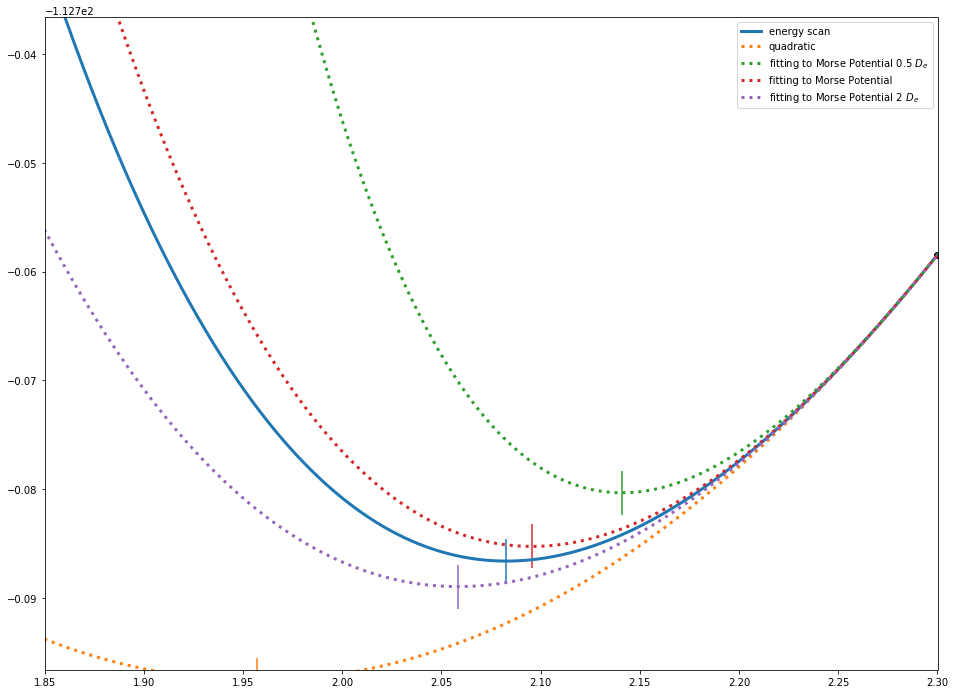

In [58]:
plt.figure(figsize=(16,12))
plt.scatter(R02,e_co2,marker="o",color="black")
plt.plot(scan_r_I,scan_e_I,lw=3,label="energy scan")
plt.scatter(scan_r_I[np.asarray(scan_e_I).argmin()],min(scan_e_I),marker='|',s=2000)
q_app=e_co2+h2*(scan_r_I-R02)**2/2+g2*(scan_r_I-R02)
plt.plot(scan_r_I,q_app,ls=":",lw=3,label="quadratic")
plt.scatter(scan_r_I[np.asarray(q_app).argmin()],min(q_app),marker='|',s=2000)
plt.plot(scan_r_I,Morse2(scan_r_I, *mpa(g2,h2,R02,.5*bde2) ,.5*bde2),ls=":" ,lw=3,\
                                         label="fitting to Morse Potential $0.5 \ D_e $")
plt.scatter(scan_r_I[np.asarray(Morse2(scan_r_I, *mpa(g2,h2,R02,.5*bde2) ,.5*bde2)).argmin()],\
            min(Morse2(scan_r_I, *mpa(g2,h2,R02,.5*bde2) ,.5*bde2)),marker='|',s=2000)

plt.plot(scan_r_I,Morse2(scan_r_I, *mpa(g2,h2,R02,bde2) ,bde2 ) ,ls=":",lw=3,\
                                         label="fitting to Morse Potential ")
plt.scatter(scan_r_I[np.asarray(Morse2(scan_r_I, *mpa(g2,h2,R02,bde2) ,bde2)).argmin()],\
            min(Morse2(scan_r_I, *mpa(g2,h2,R02,bde2) ,bde2)),marker='|',s=2000)

plt.plot(scan_r_I,Morse2(scan_r_I, *mpa(g2,h2,R02,bde2*2) ,bde2*2 ) ,ls=":",lw=3,\
                                         label="fitting to Morse Potential $2 \ D_e $")
plt.scatter(scan_r_I[np.asarray(Morse2(scan_r_I, *mpa(g2,h2,R02,2*bde2) ,2*bde2)).argmin()],\
            min(Morse2(scan_r_I, *mpa(g2,h2,R02,2*bde2) ,2*bde2)),marker='|',s=2000)

plt.ylim(e_min-.01,e_min+.05)
plt.xlim(1.85,2.3)
plt.xlabel("")
plt.legend()
plt.savefig("Morse_CO_2.png")

## Morse potential for CH$_4$

In [25]:
l=3.3376
x=-(1/24)**.5*l
z=(2/3)**.5*l+x
ch4str="C 0 0 0; H 0 0  {}; H  0  {} {}; H {} {} {}; H {} {} {}".format(z,l/3**.5,x,l/2,-l*3**.5/6,x,-l/2,-l*3**.5/6,x)

In [26]:
pcx2_ch4={"H":"pc-2",'C':bse.get_basis("pcX-2",fmt="nwchem",elements=[6])}
z

2.043854241378284

In [27]:
R03=1.9
ch4str="C 0 0 0; H 0 0  {}; H  0  {} {}; H {} {} {}; H {} {} {}".format(R03,l/3**.5,x,l/2,-l*3**.5/6,x,-l/2,-l*3**.5/6,x)
mf0=scf.RHF(gto.M(atom=ch4str,unit="bohr",basis=pcx2_ch4,verbose=0))
e0=mf0.scf()
g3=mf0.Gradients().grad()[1,2]
h3=mf0.Hessian().hess()[1,1,2,2]

In [28]:
apch4=AP(mf0,sites=[1])
apch4.build_gradient(1),apch4.build_hessian(1),apch4.build_cubic_hessian(1)

(array([-1.13940391]), array([[-1.09784524]]), array([[[0.73343511]]]))

In [29]:
De3=apch4.APDFT3(np.asarray([-1]))-e0
De3

0.7127204726223937

In [30]:
scanX=np.linspace(1.6,3,29)
ch4scan=[]
for i in scanX:
    ch4str="C 0 0 0; H 0 0  {}; H  0  {} {}; H {} {} {}; H {} {} {}".format(i,l/3**.5,x,l/2,-l*3**.5/6,x,-l/2,-l*3**.5/6,x)
    ch4scan.append(scf.RHF(gto.M(atom=ch4str,unit="bohr",basis=pcx2_ch4,verbose=0)).scf())

In [31]:
def Morse3(r,r_e,a,De):
    return De*((np.exp(a*(r_e-r))-1)**2-(np.exp(a*(r_e-R03))-1)**2)+e0

In [32]:
mpa(g3,h3,R03,De3)

(2.0304693365548236, 0.5638433519480304)

In [33]:
intX=np.linspace(1.6,3,4201)
intE=spline(scanX,ch4scan,intX)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


2.044
2.017333333333333
2.0304693365548236


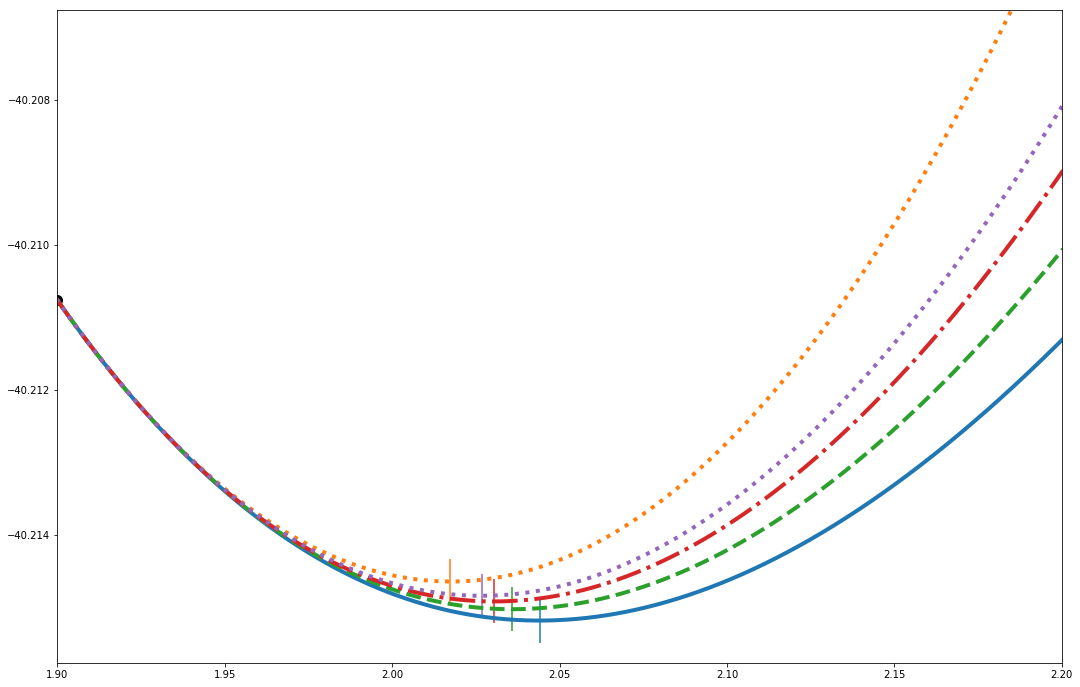

In [57]:
plt.figure(figsize=(18,12))
scanXm=np.linspace(1.4,6,201)
q_app3=e0+h3/2*(intX-R03)**2+g3*(intX-R03)
plt.scatter(R03,e0,color="black",s=100)
r_e,a=mpa(g3,h3,R03,De3)

plt.scatter(intX[np.asarray(intE).argmin()],min(intE),marker='|',s=2000)
print(intX[np.asarray(intE).argmin()])
plt.scatter(intX[np.asarray(q_app3).argmin()],min(q_app3),marker='|',s=2000)
print(intX[np.asarray(q_app3).argmin()])
r_e,a=mpa(g3,h3,R03,De3*.5)
plt.scatter(r_e,e0-Morse_dE(R03,r_e,a,De3*.5),marker='|',s=2000)
r_e,a=mpa(g3,h3,R03,De3)
print(r_e)
plt.scatter(r_e,e0-Morse_dE(R03,r_e,a,De3),marker='|',s=2000)
r_e,a=mpa(g3,h3,R03,De3*2)
plt.scatter(r_e,e0-Morse_dE(R03,r_e,a,De3*2),marker='|',s=2000)

plt.plot(intX,intE,lw=4)
plt.plot(intX, q_app3,ls=":" ,lw=4)
plt.plot(intX,Morse(intX,*mpa(g3,h3,R03,De3*.5),De3*.5,R03,e0),ls="--",lw=4 )
plt.plot(intX,Morse(intX,*mpa(g3,h3,R03,De3),De3,R03,e0),ls="-." ,lw=4)
plt.plot(intX,Morse(intX,*mpa(g3,h3,R03,De3*2),De3*2,R03,e0),ls=":" ,lw=4)
plt.ylim(e0-.005,e0+.004)
plt.xlim(1.9,2.2)
#plt.axhline(min(intE),ls=":")
plt.savefig("CH_stretching.png")